In [1]:
# Exploratory Data Analysis (EDA) Script
# notebooks/eda.ipynb

# Ensure required packages are installed in the notebook environment
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import sys
import os
sys.path.append('../src')  # so we can import the data_processing module

# Robust import: 
try:
	from data_processing import DataLoader, EDA, DataProcessor
except Exception:
	import importlib
	try:
		dp = importlib.import_module('data_processing')
	except Exception as ie:
		raise ImportError(f"Failed to import data_processing module from ../src: {ie}") from ie

	# show what's available to help diagnose naming differences
	available = [n for n in dir(dp) if not n.startswith('_')]
	print("Available in data_processing:", available)

	# attempt to bind expected names (try common alternatives for DataProcessor)
	DataLoader = getattr(dp, 'DataLoader', None)
	EDA = getattr(dp, 'EDA', None)
	DataProcessor = getattr(dp, 'DataProcessor', None)
	if DataProcessor is None:
		for alt in ('Processor', 'DataProc', 'DataProcessorClass', 'Data_Processor'):
			if hasattr(dp, alt):
				DataProcessor = getattr(dp, alt)
				print(f"Using alternative DataProcessor name: {alt}")
				break

	missing = [name for name, obj in [('DataLoader', DataLoader), ('EDA', EDA), ('DataProcessor', DataProcessor)] if obj is None]
	if missing:
		raise ImportError(f"Could not import {missing} from data_processing. Check class names/exports. Available: {available}")

# Load raw data
data_path = '../data/raw/data.csv'  # Change filename as needed
loader = DataLoader(data_path)
raw_df = loader.load_data()

# Quick overview of the raw data
raw_eda = EDA(raw_df)
raw_df.info()
raw_df.describe(include='all')
print("Raw data preview:")
print(raw_eda.dataset_overview()['preview'])
print()
print("Raw missing values (diagnostics):")
from IPython.display import display, Markdown
raw_miss = raw_eda.missing_values_table()

# suggestion map can be used when we have missing-value info to annotate suggestions
suggestion_map = {
	'none': 'No action needed',
	'median': 'Impute numeric values with median',
	'median_or_model': 'Impute with median or consider model-based imputation',
	'consider_drop_or_model': 'Consider dropping or using model-based imputation',
	'mode': 'Impute categorical values with mode',
	'mode_with_flag': 'Impute with mode and add missing flag',
	'consider_drop_or_new_category': 'Consider dropping column or create a new category'
}

if raw_miss.empty:
	display(Markdown('**Missing Values:** None detected — no NA values found in the raw dataset.'))
	# define an empty disp DataFrame so later code that expects `disp` won't fail
	disp = pd.DataFrame(columns=['Missing', 'Percent', 'Dtype', 'Nunique', 'Sample', 'Suggestion'])
else:
	disp = raw_miss.copy()
	disp['Percent'] = disp['Percent'].map(lambda x: f'{x:.1f}%')
	disp['Sample'] = disp['Sample'].map(lambda s: ', '.join(map(str, s)) if isinstance(s, (list, tuple)) else str(s))
	disp['Suggestion_Explanation'] = disp['Suggestion'].map(suggestion_map)

display(disp)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  
 15  FraudResult        

**Missing Values:** None detected — no NA values found in the raw dataset.

,Missing,Percent,Dtype,Nunique,Sample,Suggestion


In [2]:

# 2. Summary Statistics
print("\nSummary Statistics:\n", raw_eda.summary_statistics())



Summary Statistics:
        CountryCode        Amount         Value  PricingStrategy   FraudResult
count      95662.0  9.566200e+04  9.566200e+04     95662.000000  95662.000000
mean         256.0  6.717846e+03  9.900584e+03         2.255974      0.002018
std            0.0  1.233068e+05  1.231221e+05         0.732924      0.044872
min          256.0 -1.000000e+06  2.000000e+00         0.000000      0.000000
25%          256.0 -5.000000e+01  2.750000e+02         2.000000      0.000000
50%          256.0  1.000000e+03  1.000000e+03         2.000000      0.000000
75%          256.0  2.800000e+03  5.000000e+03         2.000000      0.000000
max          256.0  9.880000e+06  9.880000e+06         4.000000      1.000000


Numeric columns to plot: ['CountryCode', 'Amount', 'Value', 'PricingStrategy', 'FraudResult']


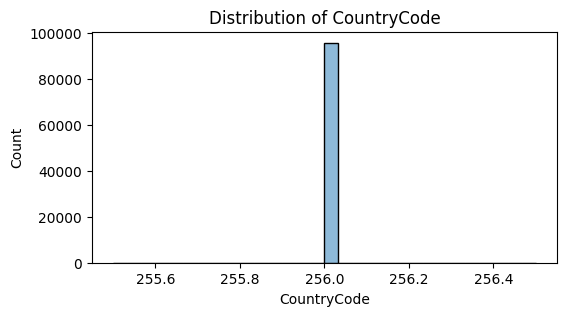

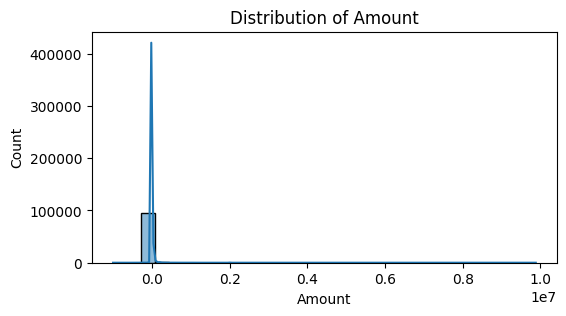

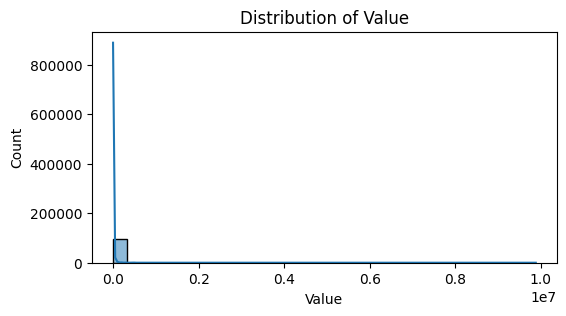

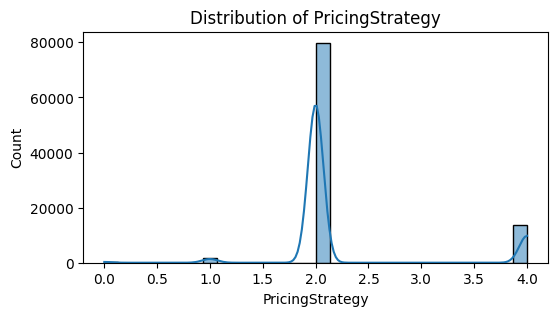

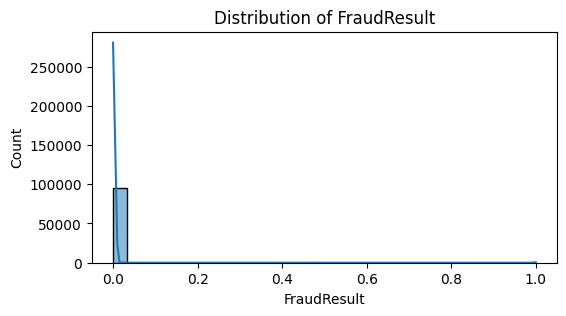

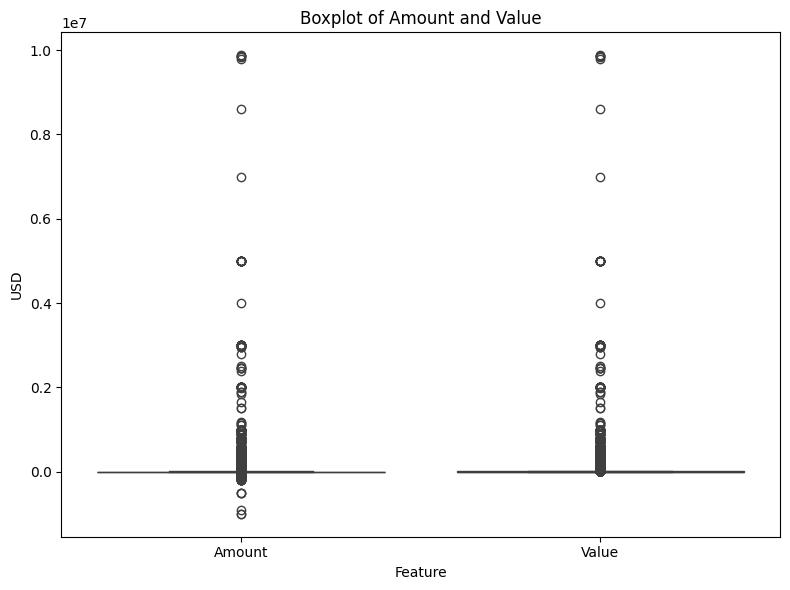

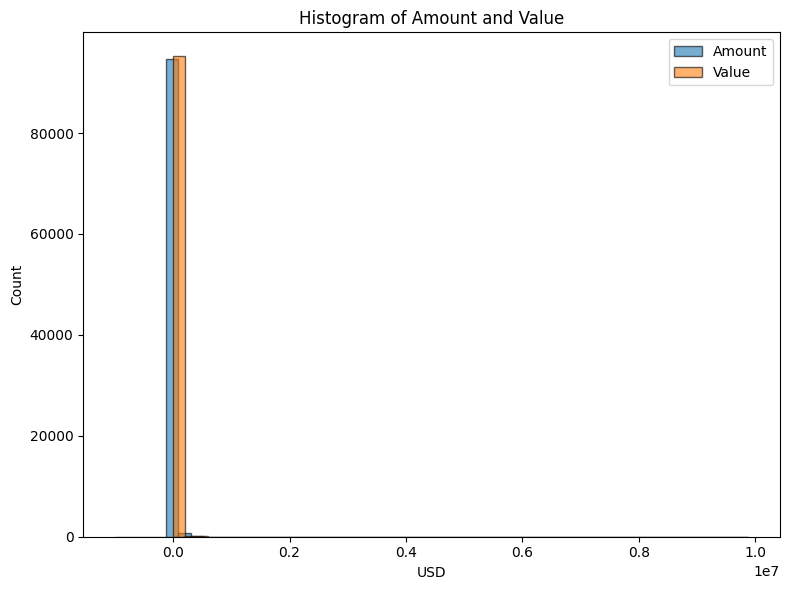

In [3]:

# 3. Numerical Feature Distributions
num_cols = raw_df.select_dtypes(include=np.number).columns.tolist()
# pick a few if there are many
num_cols = num_cols[:6] if len(num_cols) > 6 else num_cols
print('Numeric columns to plot:', num_cols)
raw_eda.plot_numerical_distributions(num_cols=num_cols)

# Assuming df is your pre-processed DataFrame and has 'Amount' and 'Value' columns.

plt.figure(figsize=(8,6))
sns.boxplot(data=raw_df[['Amount', 'Value']])
plt.title('Boxplot of Amount and Value')
plt.ylabel('USD')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
bins = 50

plt.hist(raw_df['Amount'], bins=bins, alpha=0.6, label='Amount', color='tab:blue', edgecolor='k')
plt.hist(raw_df['Value'], bins=bins, alpha=0.6, label='Value', color='tab:orange', edgecolor='k')

plt.title('Histogram of Amount and Value')
plt.xlabel('USD')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()




Categorical columns to plot: ['ProductCategory', 'ChannelId', 'ProviderId']


C:\Users\Mogassa\AppData\Local\Temp\ipykernel_10872\3690661670.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=raw_df, y=col, ax=ax, order=order, palette="Set2")
C:\Users\Mogassa\AppData\Local\Temp\ipykernel_10872\3690661670.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=raw_df, y=col, ax=ax, order=order, palette="Set2")
C:\Users\Mogassa\AppData\Local\Temp\ipykernel_10872\3690661670.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=raw_df, y=col, ax=ax, order=order, palette="Set2")


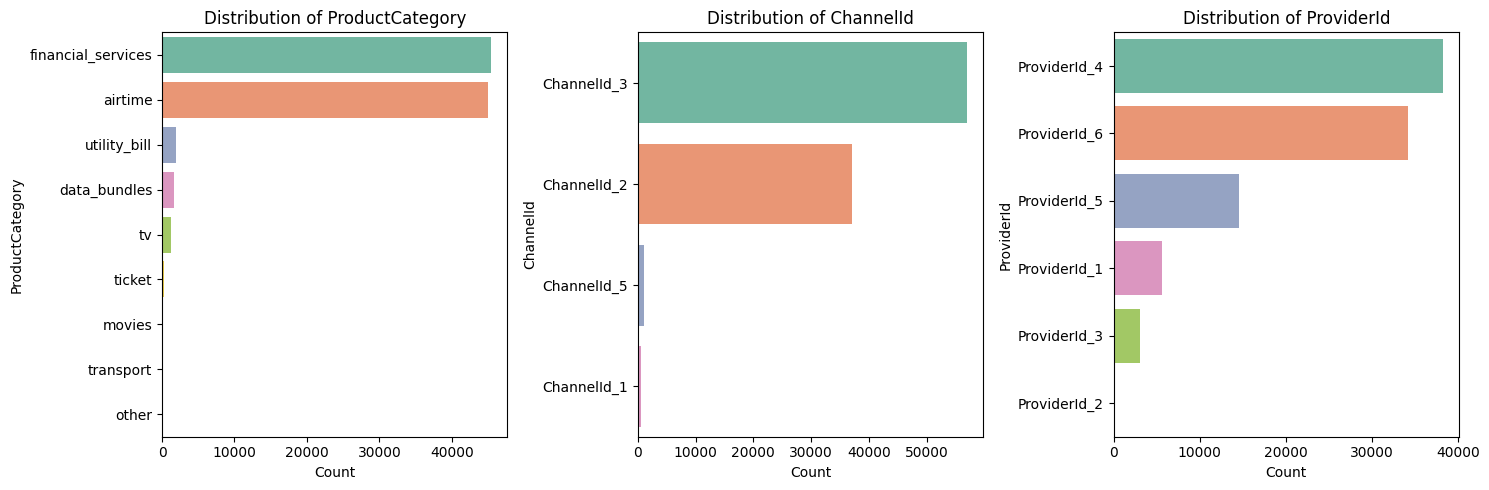

In [4]:

# 4. Categorical Feature Distributions
categorical_cols = ['ProductCategory', 'ChannelId', 'ProviderId']
print('Categorical columns to plot:', categorical_cols)

fig, axes = plt.subplots(1, len(categorical_cols), figsize=(5 * len(categorical_cols), 5))

for ax, col in zip(axes, categorical_cols):
    order = (raw_df[col].value_counts().index)
    sns.countplot(data=raw_df, y=col, ax=ax, order=order, palette="Set2")
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel("Count")
    ax.set_ylabel(col.replace('_', ' '))
    for label in ax.get_yticklabels():
        label.set_rotation(0)

plt.tight_layout()
plt.show()


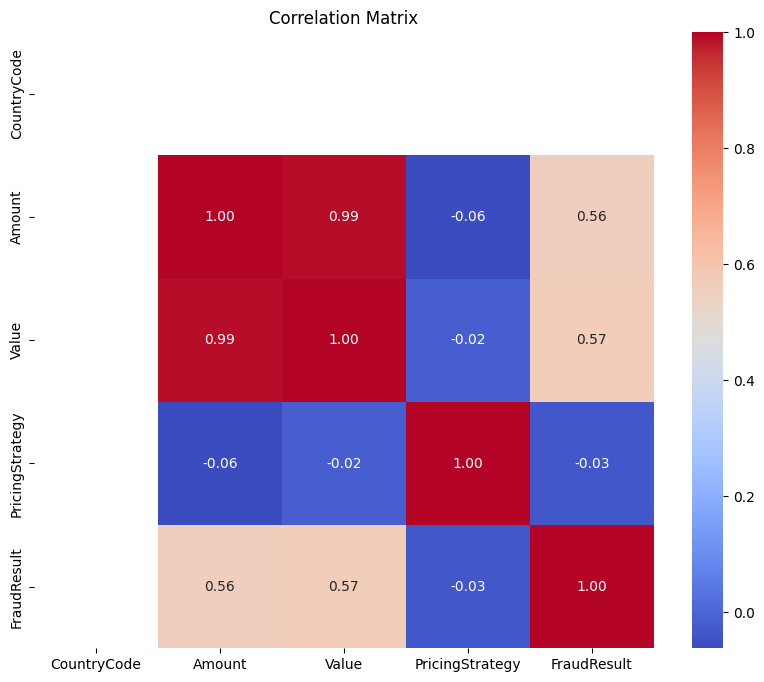

In [5]:

# 5. Correlation Analysis
corr = raw_eda.correlation_matrix()


In [6]:

# 6. Missing Values
print("\nMissing Values Table (raw):\n", raw_eda.missing_values_table())



Missing Values Table (raw):
 Empty DataFrame
Columns: [Missing, Percent, Dtype, Nunique, Sample, Suggestion]
Index: []


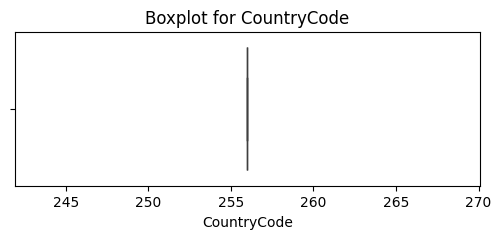

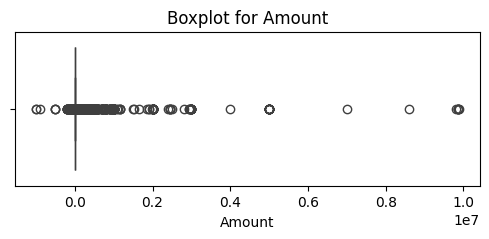

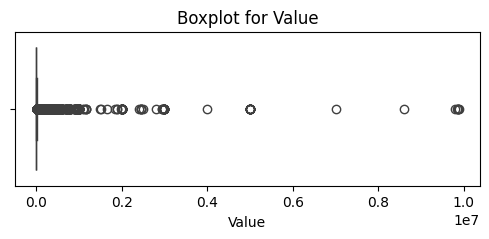

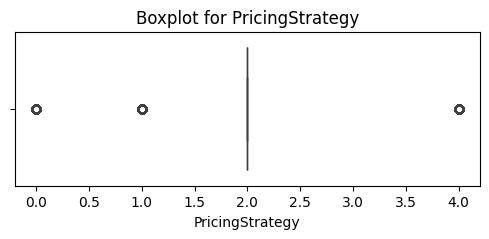

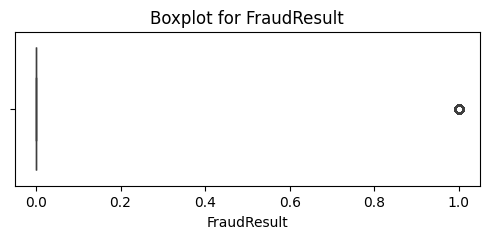

In [7]:

# 7. Outlier Detection
raw_eda.boxplot_outliers(num_cols=num_cols)


In [8]:
# 8. Processing (Task 2): normalize missing values and create processed dataset
proc = DataProcessor(raw_df)
# Use default processing config; customize as needed:
cfg = DataProcessor.ProcessConfig()
processed_df = proc.process(cfg)
processed_eda = EDA(processed_df)

print('Processed data preview:')
print(processed_eda.dataset_overview()['preview'])

print('Missing values (processed):')
from IPython.display import display, Markdown
proc_miss = processed_eda.missing_values_table()
if proc_miss.empty:
    display(Markdown('**Missing Values (processed):** None detected — preprocessing handled NA values.'))
else:
    disp2 = proc_miss.copy()
    disp2['Percent'] = disp2['Percent'].map(lambda x: f'{x:.1f}%')
    disp2['Sample'] = disp2['Sample'].map(lambda s: ', '.join(map(str, s)) if isinstance(s, (list, tuple)) else str(s))
    # reuse suggestion_map defined earlier if present, else create fallback
    try:
        disp2['Suggestion_Explanation'] = disp2['Suggestion'].map(suggestion_map)
    except NameError:
        disp2['Suggestion_Explanation'] = disp2['Suggestion']
    display(disp2)

# Compare missing counts before / after for visualization
raw_miss = raw_eda.missing_values_table()
proc_miss = processed_eda.missing_values_table()
cmp = raw_miss[['Missing']].rename(columns={'Missing':'RawMissing'})
if not proc_miss.empty:
    cmp = cmp.join(proc_miss['Missing'].rename('ProcMissing'), how='left')
else:
    cmp['ProcMissing'] = 0
cmp.fillna(0, inplace=True)

if not cmp.empty:
    ax = cmp.sort_values('RawMissing', ascending=False).head(20).plot(kind='bar', figsize=(10,4))
    ax.set_xlabel('Column')
    ax.set_ylabel('Missing count')
    ax.set_title('Missing values: raw vs processed (top 20)')
    plt.tight_layout()
    plt.show()


d:\Python\Week-4\Credit-Risk-Probability-Model-\notebooks\../src\data_processing.py:212: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna('Missing', inplace=True)


Processed data preview:
         TransactionId        BatchId       AccountId       SubscriptionId  \
0  TransactionId_76871  BatchId_36123  AccountId_3957   SubscriptionId_887   
1  TransactionId_73770  BatchId_15642  AccountId_4841  SubscriptionId_3829   
2  TransactionId_26203  BatchId_53941  AccountId_4229   SubscriptionId_222   

        CustomerId  CountryCode     ProductId  Amount  Value  \
0  CustomerId_4406          256  ProductId_10  1000.0   1000   
1  CustomerId_4406          256   ProductId_6   -20.0     20   
2  CustomerId_4683          256   ProductId_1   500.0    500   

   TransactionStartTime  ...  ProductCategory_movies  ProductCategory_other  \
0  2018-11-15T02:18:49Z  ...                   False                  False   
1  2018-11-15T02:19:08Z  ...                   False                  False   
2  2018-11-15T02:44:21Z  ...                   False                  False   

   ProductCategory_ticket  ProductCategory_transport  ProductCategory_tv  \
0            

**Missing Values (processed):** None detected — preprocessing handled NA values.

In [9]:

# Save processed and create a train/test split under repo-root data/processed/
out_path = proc.save_processed('../data/processed/processed_data.csv')

print('Processed data saved to', os.path.abspath(out_path))

# Provide explicit split paths that point to repo-root `data/processed/`
split_cfg = DataProcessor.SplitConfig(train_path='../data/processed/train.csv', test_path='../data/processed/test.csv')
train_path, test_path = proc.split_save(split_cfg)
print('Train/Test saved to', os.path.abspath(train_path), os.path.abspath(test_path))


Processed data saved to d:\Python\Week-4\Credit-Risk-Probability-Model-\data\processed\processed_data.csv
Train/Test saved to d:\Python\Week-4\Credit-Risk-Probability-Model-\data\processed\train.csv d:\Python\Week-4\Credit-Risk-Probability-Model-\data\processed\test.csv


In [10]:
# Auto-generate Top Insights from processed data (data-driven)
from IPython.display import Markdown, display
import numpy as np

# Prefer processed DataFrame in memory, else try reading the processed CSV, else use raw_df
if 'proc' in globals() and getattr(proc, 'df', None) is not None:
    df_inspect = proc.df.copy()
elif os.path.exists('../data/processed/processed_data.csv'):
    df_inspect = pd.read_csv('../data/processed/processed_data.csv')
else:
    df_inspect = raw_df.copy()

n_rows, n_cols = df_inspect.shape
numeric_cols = df_inspect.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_inspect.select_dtypes(include=['object', 'category']).columns.tolist()

# 1) Data concentration in categorical columns
concentrated = []
for c in cat_cols:
    top_share = df_inspect[c].value_counts(dropna=True, normalize=True).iloc[0] if df_inspect[c].dropna().shape[0] > 0 else 0
    if top_share >= 0.5:
        concentrated.append((c, float(top_share), df_inspect[c].value_counts().index[0]))

# 2) Missing value summary
miss = df_inspect.isnull().sum()
miss_pct = (miss / max(1, n_rows) * 100).round(1)
miss_table = pd.DataFrame({'Missing': miss, 'Percent': miss_pct})
miss_table = miss_table[miss_table['Missing'] > 0].sort_values('Missing', ascending=False)
top_missing = miss_table.head(5)

# 3) Outlier detection (z-score heuristic)
outlier_counts = {}
for c in numeric_cols:
    col = df_inspect[c].dropna()
    if col.shape[0] > 0 and col.std(ddof=0) > 0:
        z = (col - col.mean()) / col.std(ddof=0)
        outlier_counts[c] = int((z.abs() > 3).sum())
    else:
        outlier_counts[c] = 0
outliers_df = pd.Series(outlier_counts).sort_values(ascending=False).rename('OutlierCount')
top_outliers = outliers_df[outliers_df > 0].head(5)

# 4) Strong correlations among numeric features
corr_pairs = []
if len(numeric_cols) >= 2:
    corr = df_inspect[numeric_cols].corr().abs()
    for i, a in enumerate(corr.columns):
        for b in corr.columns[i+1:]:
            val = corr.loc[a, b]
            if pd.notna(val) and val >= 0.7:
                corr_pairs.append((a, b, float(val)))
    corr_pairs = sorted(corr_pairs, key=lambda x: -x[2])

# 5) Categorical diversity (high-cardinality columns)
cat_card = [(c, int(df_inspect[c].nunique(dropna=True))) for c in cat_cols]
cat_card_sorted = sorted(cat_card, key=lambda x: -x[1])

# Build human-friendly insights
insights_lines = []
insights_lines.append(f"**Dataset:** {n_rows:,} rows × {n_cols:,} columns.")

if concentrated:
    for c, share, topv in concentrated:
        insights_lines.append(f"**Concentration:** `{c}` is concentrated: top value `{topv}` covers {share*100:.1f}% of non-null rows.")
else:
    insights_lines.append("**Concentration:** No categorical column has a single value covering >=50% of non-null rows.")

if not top_missing.empty:
    rows = [f"`{idx}`: {int(r['Missing']):,} ({r['Percent']}%)" for idx, r in top_missing.iterrows()]
    insights_lines.append("**Missing values (top columns):** " + "; ".join(rows))
else:
    insights_lines.append("**Missing values:** No missing values detected after processing.")

if not top_outliers.empty:
    out_rows = [f"`{idx}`: {int(cnt)} outliers" for idx, cnt in top_outliers.items()]
    insights_lines.append("**Outliers (z-score > 3), top numeric columns:** " + "; ".join(out_rows))
else:
    insights_lines.append("**Outliers:** No extreme outliers (z-score > 3) found in numeric columns.")

if corr_pairs:
    top_corr = ", ".join([f"`{a}`↔`{b}`={val:.2f}" for a, b, val in corr_pairs[:5]])
    insights_lines.append("**Strong correlations (|r|>=0.7):** " + top_corr)
else:
    insights_lines.append("**Correlations:** No strong correlations (|r|>=0.7) found among numeric features.")

if cat_card_sorted:
    top_high = cat_card_sorted[:3]
    top_low = sorted(cat_card_sorted, key=lambda x: x[1])[:3]
    insights_lines.append("**Categorical diversity:** top high-cardinality columns: " + ", ".join([f"`{c}`({n})" for c, n in top_high]))
    insights_lines.append("**Categorical diversity:** top low-cardinality columns: " + ", ".join([f"`{c}`({n})" for c, n in top_low]))

# Display
display(Markdown("### Top EDA Insights (data-driven)"))
for line in insights_lines:
    display(Markdown(f"- {line}"))

# Also show supporting small tables for quick inspection
if not miss_table.empty:
    display(Markdown('**Missing values (top 10)**'))
    display(miss_table.head(10))
if not top_outliers.empty:
    display(Markdown('**Outlier counts (top numeric columns)**'))
    display(top_outliers.head(10))
if corr_pairs:
    display(Markdown('**Strong correlation pairs (|r|>=0.7)**'))
    display(pd.DataFrame(corr_pairs, columns=['feature_a', 'feature_b', 'abs_corr']).head(10))


### Top EDA Insights (data-driven)

- **Dataset:** 95,662 rows × 39 columns.

- **Concentration:** No categorical column has a single value covering >=50% of non-null rows.

- **Missing values:** No missing values detected after processing.

- **Outliers (z-score > 3), top numeric columns:** `PricingStrategy`: 385 outliers; `Amount`: 269 outliers; `Value`: 269 outliers; `FraudResult`: 193 outliers

- **Strong correlations (|r|>=0.7):** `Amount`↔`Value`=0.99

- **Categorical diversity:** top high-cardinality columns: `TransactionId`(95662), `BatchId`(94809), `TransactionStartTime`(94556)

- **Categorical diversity:** top low-cardinality columns: `ProductId`(23), `SubscriptionId`(3627), `AccountId`(3633)

**Outlier counts (top numeric columns)**

PricingStrategy    385
Amount             269
Value              269
FraudResult        193
Name: OutlierCount, dtype: int64

**Strong correlation pairs (|r|>=0.7)**

,feature_a,feature_b,abs_corr
0,Amount,Value,0.989692
